IMPORT THE LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
%matplotlib inline

**Read** **Dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
data = pd.read_csv("/content/drive/My Drive/Untitled folder/spam.csv",delimiter=',',encoding='latin-1')

In [4]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


**PRE** **PROCESSING**

In [5]:
data = data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)

In [6]:
data = data.rename(columns={'v1':'spam','v2':'text'})

In [7]:
data.head()

,spam,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
data.isnull().sum()

spam    0
text    0
dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   spam    5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [10]:
data["text Length"]=data["text"].apply(len)

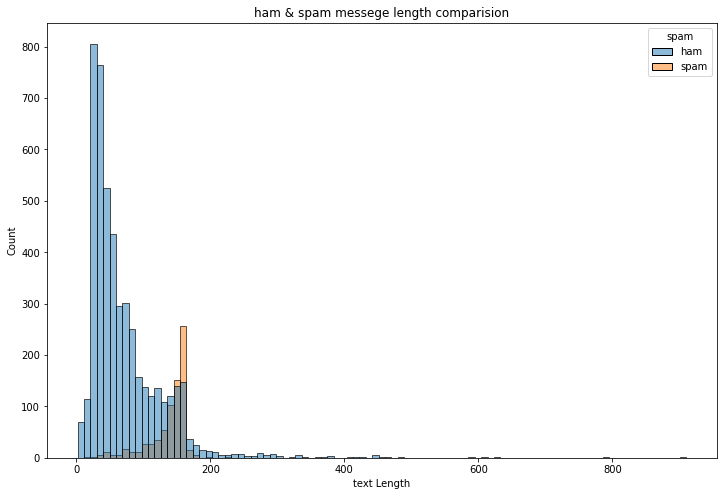

In [11]:
fig=plt.figure(figsize=(12,8))
sns.histplot(
    x=data["text Length"],
    hue=data["spam"]
)
plt.title("ham & spam messege length comparision")
plt.show()

In [12]:
ham_desc=data[data["spam"]=="ham"]["text Length"].describe()
spam_desc=data[data["spam"]=="spam"]["text Length"].describe()

print("Ham Messege Length Description:\n",ham_desc)
print("************************************")
print("Category Message Length Description:\n",spam_desc)

Ham Messege Length Description:
 count    4825.000000
mean       71.023627
std        58.016023
min         2.000000
25%        33.000000
50%        52.000000
75%        92.000000
max       910.000000
Name: text Length, dtype: float64
************************************
Category Message Length Description:
 count    747.000000
mean     138.866131
std       29.183082
min       13.000000
25%      132.500000
50%      149.000000
75%      157.000000
max      224.000000
Name: text Length, dtype: float64


In [13]:
data.describe(include="all")

,spam,text,text Length
count,5572,5572,5572.000000
unique,2,5169,NaN
top,ham,"Sorry, I'll call later",NaN
freq,4825,30,NaN
mean,NaN,NaN,80.118808
std,NaN,NaN,59.690841
min,NaN,NaN,2.000000
25%,NaN,NaN,36.000000
50%,NaN,NaN,61.000000
75%,NaN,NaN,121.000000


In [14]:
data["spam"].value_counts()

ham     4825
spam     747
Name: spam, dtype: int64

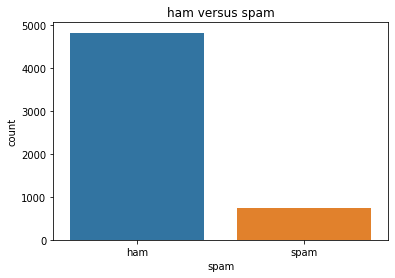

In [15]:
sns.countplot(
    data=data,
    x="spam"
)
plt.title("ham versus spam")
plt.show()

In [16]:
ham_count=data["spam"].value_counts()[0]
spam_count=data["spam"].value_counts()[1]

total_count=data.shape[0]

print("Ham contains:{:.2f}% of total data.".format(ham_count/total_count*100))
print("Spam contains:{:.2f}% of total data.".format(spam_count/total_count*100))

Ham contains:86.59% of total data.
Spam contains:13.41% of total data.


In [56]:
data.head()

,spam,text,text Length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


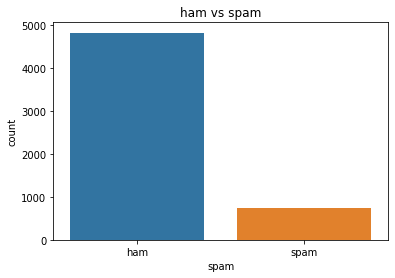

In [57]:
sns.countplot(
    data=data,
    x="spam"
)
plt.title("ham vs spam")
plt.show()

In [58]:
data["Label"]=data["spam"].map(
    {
        "ham":0,
        "spam":1
    }
)

In [59]:
data.head()

,spam,text,text Length,Label
0,ham,"Go until jurong point, crazy.. Available only ...",111,0
1,ham,Ok lar... Joking wif u oni...,29,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,1
3,ham,U dun say so early hor... U c already then say...,49,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,0


In [61]:
import re
import nltk
nltk.download()

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stemmer=PorterStemmer()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> l
Packages:
  [ ] abc................. Australian Broadcasting Commission 2006
  [ ] alpino.............. Alpino Dutch Treebank
  [ ] averaged_perceptron_tagger Averaged Perceptron Tagger
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [ ] basque_grammars..... Grammars for Basque
  [ ] biocreative_ppi..... BioCreAtIvE (Critical Assessment of Information
                           Extraction Systems in Biology)
  [ ] bllip_wsj_no_aux.... BLLIP Parser: WSJ Model
  [ ] book_grammars....... Grammars from NLTK Book
  [ ] brown............... Brown Corpus
  [ ] brown_tei........... Brown Corpus (TEI XML Version)
  [ ] cess_cat............ CESS-CAT Treebank
  [

In [62]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [63]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [64]:
data["No_of_Characters"] = data["text"].apply(len)
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["text"]),
axis=1).apply(len)
data["No_of_sentence"]=data.apply(lambda row: nltk.sent_tokenize(row["text"]),
axis=1).apply(len)
data.describe().T

,count,mean,std,min,25%,50%,75%,max
text Length,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
Label,5572.0,0.134063,0.340751,0.0,0.0,0.0,0.0,1.0
No_of_Characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
No_of_Words,5572.0,18.695621,13.742587,1.0,9.0,15.0,27.0,220.0
No_of_sentence,5572.0,1.970747,1.417778,1.0,1.0,1.0,2.0,28.0


In [65]:
data.head()

,spam,text,text Length,Label,No_of_Characters,No_of_Words,No_of_sentence
0,ham,"Go until jurong point, crazy.. Available only ...",111,0,111,24,2
1,ham,Ok lar... Joking wif u oni...,29,0,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,1,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,0,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,0,61,15,1


<Figure size 1296x864 with 0 Axes>

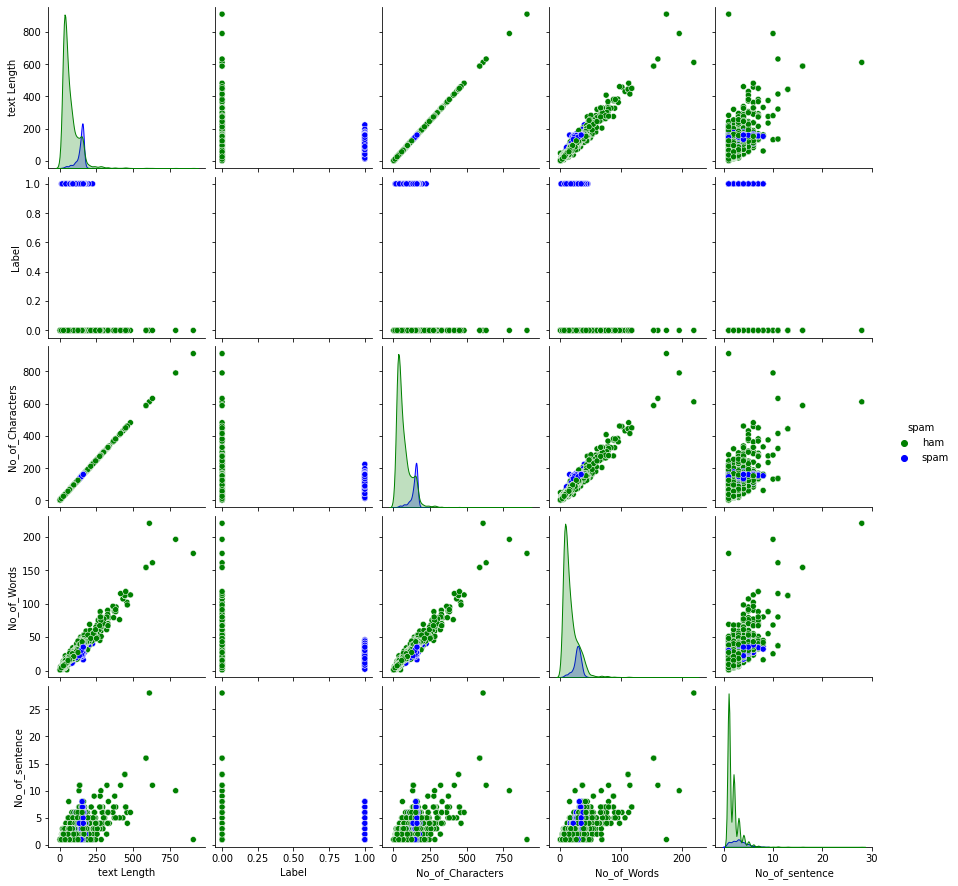

In [69]:
plt.figure(figsize=(18,12))
fg = sns.pairplot(data=data, hue="spam",palette=["green","blue"])
plt.show(fg)

In [112]:
def Clean(Text):
 sms = re.sub('[^a-zA-Z]', ' ', Text) 
 sms = sms.lower() 
 sms = sms.split()
 sms = ' '.join(sms)
 return sms
data["Clean_Text"] = data["text"].apply(Clean)

In [75]:
data["Tokenize_Text"]=data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]),
axis=1)

In [96]:
def remove_stopwords(text):
 stop_words = set(stopwords.words("english"))
 filtered_text = [word for word in text if word not in stop_words]
 return filtered_text


data["Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)

In [78]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [97]:
lemmatizer = WordNetLemmatizer()
def lemmatize_word(text):
 lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
 return lemmas

data["Lemmatized_Text"] = data["Nostopword_Text"].apply(lemmatize_word)

In [98]:
corpus= []
for i in data["Lemmatized_Text"]:
  msg = ' '.join([row for row in i])
  corpus.append(msg)
corpus[:5]

['go jurong point crazy available bugis n great world la e buffet cine get amore wat',
 'ok lar joke wif u oni',
 'free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply',
 'u dun say early hor u c already say',
 'nah think go usf live around though']

In [99]:
data.tail()

,spam,text,text Length,Label,No_of_Characters,No_of_Words,No_of_sentence,Clean_Text,Tokenize_Text,Nostopword_Text,Lemmatized_Text
5567,spam,This is the 2nd time we have tried 2 contact u...,161,1,161,35,4,this is the nd time we have tried contact u u ...,"[this, is, the, nd, time, we, have, tried, con...","[nd, time, tried, contact, u, u, pound, prize,...","[nd, time, try, contact, u, u, pound, prize, c..."
5568,ham,Will Ì_ b going to esplanade fr home?,37,0,37,9,1,will b going to esplanade fr home,"[will, b, going, to, esplanade, fr, home]","[b, going, esplanade, fr, home]","[b, go, esplanade, fr, home]"
5569,ham,"Pity, * was in mood for that. So...any other s...",57,0,57,15,2,pity was in mood for that so any other suggest...,"[pity, was, in, mood, for, that, so, any, othe...","[pity, mood, suggestions]","[pity, mood, suggestions]"
5570,ham,The guy did some bitching but I acted like i'd...,125,0,125,27,1,the guy did some bitching but i acted like i d...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, interested, buyin...","[guy, bitch, act, like, interest, buy, somethi..."
5571,ham,Rofl. Its true to its name,26,0,26,7,2,rofl its true to its name,"[rofl, its, true, to, its, name]","[rofl, true, name]","[rofl, true, name]"


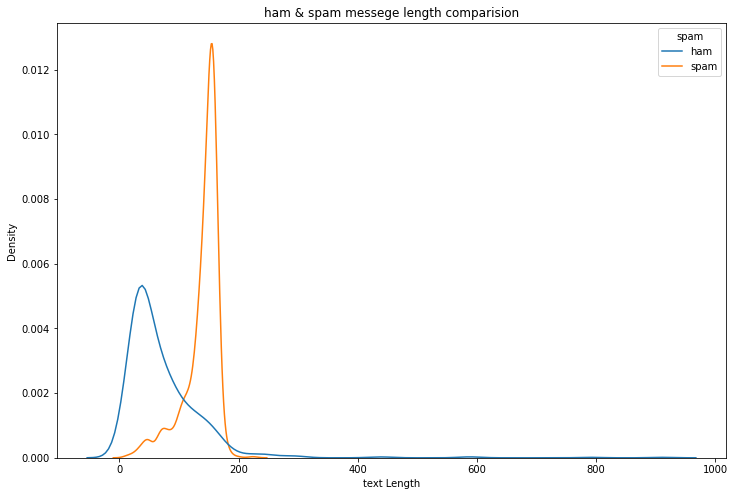

In [100]:
fig=plt.figure(figsize=(12,8))
sns.kdeplot(
    x=df["text Length"],
    hue=df["spam"]
)
plt.title("ham & spam messege length comparision")
plt.show()

In [41]:
from sklearn.model_selection import train_test_split

**CREATE** **MODEL**

In [42]:
from sklearn.preprocessing import LabelEncoder
from keras.layers import LSTM, Dense,SimpleRNN

In [101]:
X = data.text
Y = data.spam
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)


In [102]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [103]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

**Add** **Layers** (**LSTM**, **Dense**-(**Hidden** **Layers**), **Output**)

In [104]:
def RNN():
 inputs = Input(name='inputs',shape=[max_len])
 layer = Embedding(max_words,50,input_length=max_len)(inputs)
 layer = LSTM(64)(layer)
 layer = Dense(256,name='FC1')(layer)
 layer = Activation('relu')(layer)
 layer = Dropout(0.5)(layer)
 layer = Dense(1,name='out_layer')(layer)
 layer = Activation('sigmoid')(layer)
 model = Model(inputs=inputs,outputs=layer)
 return model

**Compile** **the** **Model**

In [105]:
model= RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'
])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

**Fit** **the** **Model**

In [107]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)
])


Epoch 1/10
30/30 [==============================] - 12s 285ms/step - loss: 0.3067 - accuracy: 0.8933 - val_loss: 0.1442 - val_accuracy: 0.9757
Epoch 2/10
30/30 [==============================] - 8s 262ms/step - loss: 0.0746 - accuracy: 0.9826 - val_loss: 0.0841 - val_accuracy: 0.9789


**Save** **the** **Model**

In [108]:
model.save('sms_classifier.h5')

 **Test** **the** **Model**

In [109]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [110]:
accurate = model.evaluate(test_sequences_matrix,Y_test)

27/27 [==============================] - 1s 23ms/step - loss: 0.0526 - accuracy: 0.9809


In [111]:
print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accurate[0],accurate[1]))

Test set
 Loss: 0.053
 Accuracy: 0.981
